In [2]:
import mne
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.fft import fft
import os
import mne
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
folder_path = 'data'
file_names = [f for f in os.listdir(folder_path) if f.endswith('.bdf')]

X_all = []
y_all = []
durations = []
for file_name in file_names[:20]:
    file_path = os.path.join(folder_path, file_name)
    raw = mne.io.read_raw_bdf(file_path, preload=True)

    events = mne.find_events(raw, shortest_event=1)

    event_id = {'awe': 9, 
                'frustration': 10,
                'joy': 11,
                'anger': 12,
                'happy': 13,
                'sad': 14,
                'love': 15,
                'fear': 16,
                'compassion': 17,
                'jealousy': 18,
                'content': 19,
                'grief': 20,
                'relief': 21,
                'excite': 22,
                'disgust': 23,
                'none': 0  # added this line to include non-events
                }

    avg_duration = np.mean(np.diff(events[:, 0]))

    none_events = []
    none_count = 0  # counter for 'none' events
    for i in range(1, len(events)):
        gap = events[i][0] - events[i-1][0]
        if gap > avg_duration * 2:  # only add "none" event if gap is longer than twice the average duration
            none_start = events[i-1][0] + gap // 2  # start "none" event in the middle of the gap
            none_events.append([none_start, 0, event_id['none']])
            none_count += 1
            if none_count >= 1:  # limit to 2 'none' events per file
                break

    events = np.vstack((events, none_events))
    events = events[events[:, 0].argsort()]  # sort events by time

    existing_event_ids = set(events[:, 2])
    filtered_event_id = {k: v for k, v in event_id.items() if v in existing_event_ids}
    
    epochs = mne.Epochs(raw, events, filtered_event_id, tmin=-3, tmax=2, baseline=None)

    X = epochs.get_data()
    y = epochs.events[:, -1]
    print('File', file_name, 'shape: ', X.shape, y.shape)
    X_all.append(X)
    y_all.append(y)

    for i in range(1, len(events)):
        start_time_current_event = events[i - 1, 0]
        start_time_next_event = events[i, 0]
        duration = (start_time_next_event - start_time_current_event) / raw.info['sfreq']
        event_id = events[i - 1, 2]
        if event_id >= 9 and event_id <= 23:
            durations.append((event_id, duration))

X = np.concatenate(X_all)
y = np.concatenate(y_all)


Extracting EDF parameters from C:\Artificial Intelligence\S8\MachinePerception\project\data\eeg_recording_1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1155327  =      0.000 ...  4512.996 secs...
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
86 events found
Event IDs: [  1   2   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  21  22  23  24  25  26  30 100]
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 16 events and 1281 original time points ...
0 bad epochs dropped
File eeg_recording_1.bdf shape:  (16, 265, 1281) (16,)
Extracting EDF parameters from C:\Artificial Intelligence\S8\MachinePerception\project\data\eeg_recording_10.bdf...
BDF file detected
Setting channel info structure...
Creating raw.inf

In [4]:
def data_extension(X, y, n_segments):
    extented_X = []
    extended_y = []
    
    segment_duration = int(X.shape[2] / n_segments)
    
    for i in range(X.shape[0]):
        for j in range(n_segments):
            start = j * segment_duration
            segment = X[i, :, start : start + segment_duration]
            extented_X.append(segment)
            extended_y.append(y[i])

    return np.array(extented_X), np.array(extended_y)

In [5]:
print(X.shape, y.shape)
X, y = data_extension(X, y, 5)
print(X.shape, y.shape)

(320, 265, 1281) (320,)
(1600, 265, 256) (1600,)


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

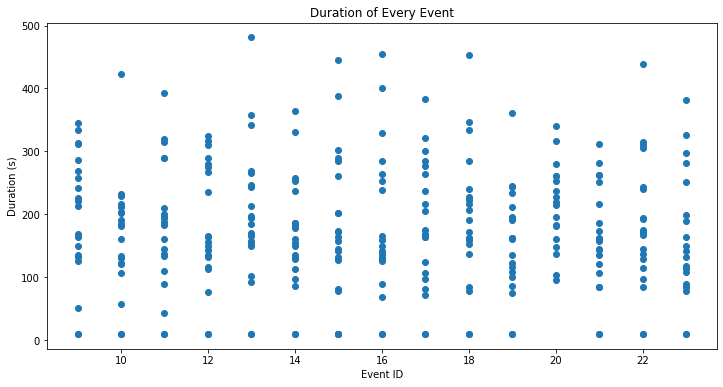

In [7]:
# Plot the duration of every event
event_ids, event_durations = zip(*durations)
plt.figure(figsize=(12, 6))
plt.scatter(event_ids, event_durations)
plt.xlabel('Event ID')
plt.ylabel('Duration (s)')
plt.title('Duration of Every Event')
plt.show()

In [8]:
def data_augmentation(X, y, n_segments, segment_duration=None, is_noise = True, noise_std=None, noise_per_channel=False, random_seed=42):
    np.random.seed(random_seed)
    augmented_X = []
    augmented_y = []
    
    if segment_duration is None:
        segment_duration = int(0.5 * X.shape[2])

    if noise_std is None:
        if noise_per_channel:
            noise_std = np.std(X, axis=(0, 2)) / 10
        else:
            noise_std = np.std(X) / 10
    
    if not is_noise:
        noise_std = 0

    for i in range(X.shape[0]):
        for _ in range(n_segments):
            start = np.random.randint(0, X.shape[2] - segment_duration)
            segment = X[i, :, start : start + segment_duration]
            noise = np.random.normal(0, noise_std, segment.shape[::-1]).transpose()
            augmented_segment = segment + noise
            augmented_X.append(augmented_segment)
            augmented_y.append(y[i])

    return np.array(augmented_X), np.array(augmented_y)

def extract_segments(X, segment_duration):
    if segment_duration is None:
        segment_duration = int(0.5 * X.shape[2])
    n_segments = X.shape[2] // segment_duration
    extracted_X = []

    for i in range(X.shape[0]):
        for j in range(n_segments):
            start = j * segment_duration
            segment = X[i, :, start : start + segment_duration]
            extracted_X.append(segment)

    return np.array(extracted_X)

In [19]:
X_train.shape, data_augmentation(X_train, y_train, 3)[0].shape

((240, 265, 1281), (720, 265, 640))

In [76]:
def test_all_classifiers(X_train, X_test, y_train, y_test, augmentation = False):
#     X, y = data_augmentation(X, y, 12, is_noise=is_noise, noise_per_channel=noise_per_channel)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    if augmentation:
        X_train, y_train = data_augmentation(X_train, y_train, 5, is_noise=True, noise_per_channel=True)

        X_test = extract_segments(X_test, segment_duration=int(0.5 * X.shape[2]))
        y_test = np.repeat(y_test, X_test.shape[0] // y_test.shape[0])
    
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    # Logistic Regression
    pipeline = make_pipeline(
        StandardScaler(),
        LogisticRegression()
    )
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
#     print(y_test, y_pred)
    log_accuracy = accuracy_score(y_test, y_pred)
    print(f'Logistic Regression accuracy: {log_accuracy:.2f}')

    # Support Vector Classification
    pipeline = make_pipeline(
        StandardScaler(),
        SVC()
    )
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    svc_accuracy = accuracy_score(y_test, y_pred)
    print(f'SVC accuracy: {svc_accuracy:.2f}')
    
    # Random Forest Classification
    pipeline = make_pipeline(
        StandardScaler(),
        RandomForestClassifier()
    )
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    rand_accuracy = accuracy_score(y_test, y_pred)
    print(f'Random Forest accuracy: {rand_accuracy:.2f}')
    
    # K-Nearest Neighbors Classification
    pipeline = make_pipeline(
        StandardScaler(),
        KNeighborsClassifier()
    )
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    knn_accuracy = accuracy_score(y_test, y_pred)
    print(f'K-Nearest Neighbors accuracy: {knn_accuracy:.2f}')
    
    return log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy


In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1200, 265, 256), (400, 265, 256), (1200,), (400,))

In [20]:
# print('NOISE NOT PER CHANNEL')
# test_all_classifiers(X_train, X_test, y_train, y_test)

print("\n============================\n")
print('NOISE PER CHANNEL')
test_all_classifiers(X_train, X_test, y_train, y_test)

print("\n============================\n")
print('NO NOISE')
#test_all_classifiers(X_train, X_test, y_train, y_test, augmentation=True)



NOISE PER CHANNEL


C:\Users\konsz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression accuracy: 0.00
SVC accuracy: 0.01
Random Forest accuracy: 0.00
K-Nearest Neighbors accuracy: 0.00


NO NOISE


In [27]:
X_train[y_train == 9, 0].shape

(15, 1281)

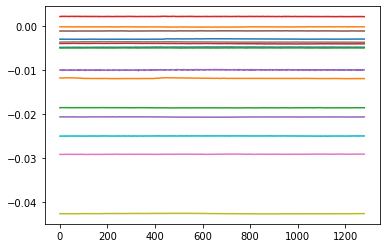

In [57]:
for row in X_train[y_train == 11, 10]:
    plt.plot(row)
plt.show()

In [71]:
new_X = X.copy()
new_y = y.copy()

In [72]:
np.mean(new_X, axis=2).shape

(320, 265)

In [73]:
new_X = new_X - np.mean(new_X, axis=2).reshape(new_X.shape[0], new_X.shape[1], 1)

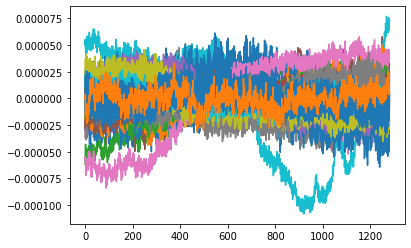

In [115]:
for row in new_X[new_y == 15, 5]:
    plt.plot(row)
plt.show()

In [75]:
X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size=0.25, random_state=42, stratify=new_y)

print("\n============================\n")
print('NOISE PER CHANNEL')
test_all_classifiers(X_train, X_test, y_train, y_test)

print("\n============================\n")
print('NO NOISE')



NOISE PER CHANNEL
Logistic Regression accuracy: 0.04
SVC accuracy: 0.03
Random Forest accuracy: 0.56
K-Nearest Neighbors accuracy: 0.07


NO NOISE


In [77]:
test_all_classifiers(X_train, X_test, y_train, y_test, augmentation=True)

C:\Users\konsz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression accuracy: 0.04
SVC accuracy: 0.04
Random Forest accuracy: 0.03
K-Nearest Neighbors accuracy: 0.04


(0.0375, 0.0375, 0.03125, 0.0375)

In [116]:
positive = [9, 11, 13, 15, 17, 19, 21, 22]
negative = [10, 12, 14, 16, 18, 20, 23]

pos_X = X[np.isin(new_y, positive)]
pos_y = np.ones(pos_X.shape[0])

neg_X = X[np.isin(new_y, negative)]
neg_y = np.zeros(neg_X.shape[0])

limited_X = np.concatenate([pos_X, neg_X])
limited_y = np.concatenate([pos_y, neg_y])

order = np.arange(limited_y.shape[0])
np.random.shuffle(order)

limited_X = limited_X[order]
limited_y = limited_y[order]

In [117]:
X_train, X_test, y_train, y_test = train_test_split(limited_X, limited_y, test_size=0.25, random_state=42, stratify=limited_y)

print("\n============================\n")
print('NOISE PER CHANNEL')
test_all_classifiers(X_train, X_test, y_train, y_test)

print("\n============================\n")
print('NO NOISE')



NOISE PER CHANNEL


C:\Users\konsz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression accuracy: 0.39
SVC accuracy: 0.45
Random Forest accuracy: 0.29
K-Nearest Neighbors accuracy: 0.29


NO NOISE


### Basic FFT

Magnitude:


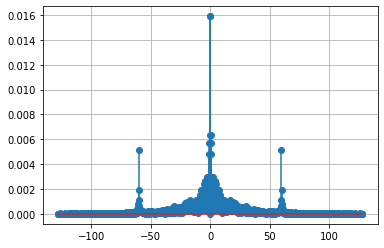

Real part:


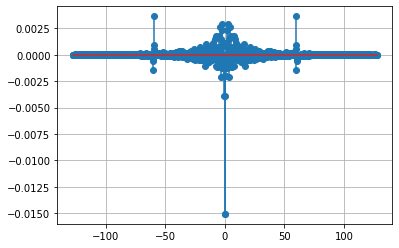

Imaginary part:


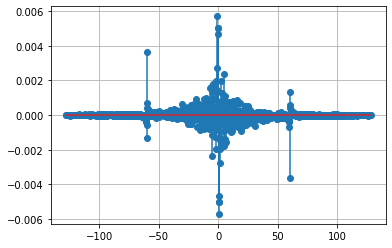

In [78]:
plot_x = np.fft.fftfreq(1281, 1/raw.info['sfreq'])
plot_y = np.fft.fft(new_X)

print("Magnitude:")
plt.stem(plot_x, np.abs(plot_y[0,0]), use_line_collection=True)
plt.grid()
plt.show()

print("Real part:")
plt.stem(plot_x, np.real(plot_y[0,0]), use_line_collection=True)
plt.grid()
plt.show()

print("Imaginary part:")
plt.stem(plot_x, np.imag(plot_y[0,0]), use_line_collection=True)
plt.grid()
plt.show()

**FFT plots with the dominating magnitude removed**

Magnitude:


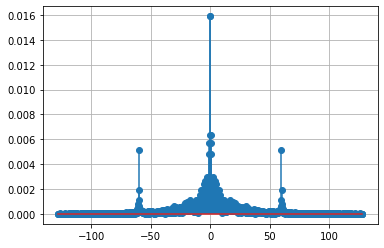

Real part:


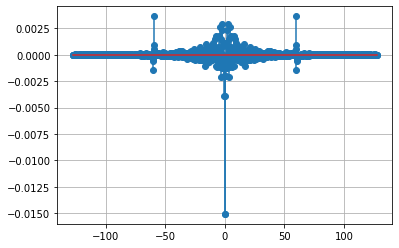

Imaginary part:


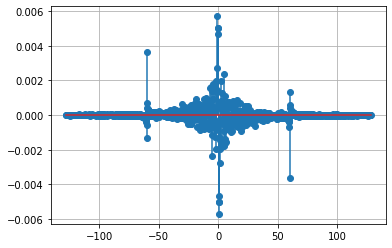

In [79]:
print("Magnitude:")
plt.stem(plot_x[1:], np.abs(plot_y[0,0,1:]), use_line_collection=True)
plt.grid()
plt.show()

print("Real part:")
plt.stem(plot_x[1:], np.real(plot_y[0,0,1:]), use_line_collection=True)
plt.grid()
plt.show()

print("Imaginary part:")
plt.stem(plot_x[1:], np.imag(plot_y[0,0,1:]), use_line_collection=True)
plt.grid()
plt.show()

In [80]:
fft_X = np.fft.fft(X)
# concatenate real and imaginary parts
fft_X = np.concatenate([np.real(fft_X), np.imag(fft_X)], axis=1)
test_all_classifiers(fft_X, y)

TypeError: test_all_classifiers() missing 2 required positional arguments: 'y_train' and 'y_test'

In [ ]:
test_all_classifiers(fft_X, y, noise_per_channel=True)

In [ ]:
test_all_classifiers(fft_X, y, is_noise=False)

In [ ]:
fft_X = np.fft.fft(X)
fft_X = np.concatenate([np.real(fft_X), np.imag(fft_X), X], axis=1)
test_all_classifiers(fft_X, y, noise_per_channel=True)

In [97]:
import scipy.signal

# Power Spectral Density
freqs, psd = scipy.signal.welch(limited_X, fs=raw.info['sfreq'], nperseg=180, noverlap=90, axis=1)

# concatenate real and imaginary parts
psd_X = np.concatenate([np.real(psd), np.imag(psd)], axis=1)

In [99]:
X_train_psd, X_test_psd, y_train_psd, y_test_psd = train_test_split(psd_X, limited_y, test_size=0.25, random_state=42, stratify=limited_y)

print('NO NOISE')
test_all_classifiers(X_train_psd, X_test_psd, y_train_psd, y_test_psd)

print("\n============================\n")
print('NOISE')
test_all_classifiers(X_train_psd, X_test_psd, y_train_psd, y_test_psd, noise_per_channel=True)

NO NOISE


C:\Users\konsz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression accuracy: 0.49
SVC accuracy: 0.48
Random Forest accuracy: 0.55
K-Nearest Neighbors accuracy: 0.48


NOISE


TypeError: test_all_classifiers() got an unexpected keyword argument 'noise_per_channel'

In [100]:
test_all_classifiers(X_train_psd, X_test_psd, y_train_psd, y_test_psd, augmentation=True)

C:\Users\konsz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression accuracy: 0.47
SVC accuracy: 0.53
Random Forest accuracy: 0.47
K-Nearest Neighbors accuracy: 0.46


(0.4666666666666667, 0.5333333333333333, 0.47333333333333333, 0.46)

In [ ]:
psd_X = np.concatenate([np.real(psd), np.imag(psd), X], axis=1)

test_all_classifiers(psd_X, y, noise_per_channel=True)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Power Spectral Density
freqs, psd = scipy.signal.welch(X, fs=raw.info['sfreq'], nperseg=180, noverlap=90, axis=1)

# Average PSD across all time series
mean_psd = np.mean(psd, axis=0)

plt.figure(figsize=(10, 6))
plt.semilogy(freqs, mean_psd)
plt.title('Power Spectral Density (PSD)')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.grid()
plt.show()

### Test different times

In [ ]:
def load_data(tmin=-0.2,tmax=0.5):
    folder_path = 'data'
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.bdf')]

    X_all = []
    y_all = []
    durations = []
    for file_name in file_names:
        file_path = os.path.join(folder_path, file_name)
        raw = mne.io.read_raw_bdf(file_path, preload=True)

        events = mne.find_events(raw, shortest_event=1)

        event_id = {'awe': 9, 
                    'frustration': 10,
                    'joy': 11,
                    'anger': 12,
                    'happy': 13,
                    'sad': 14,
                    'love': 15,
                    'fear': 16,
                    'compassion': 17,
                    'jealousy': 18,
                    'content': 19,
                    'grief': 20,
                    'relief': 21,
                    'excite': 22,
                    'disgust': 23,
                    'none': 0  # added this line to include non-events
                    }

        avg_duration = np.mean(np.diff(events[:, 0]))

        none_events = []
        none_count = 0  # counter for 'none' events
        for i in range(1, len(events)):
            gap = events[i][0] - events[i-1][0]
            if gap > avg_duration * 2:  # only add "none" event if gap is longer than twice the average duration
                none_start = events[i-1][0] + gap // 2  # start "none" event in the middle of the gap
                none_events.append([none_start, 0, event_id['none']])
                none_count += 1
                if none_count >= 1:  # limit to 2 'none' events per file
                    break

        events = np.vstack((events, none_events))
        events = events[events[:, 0].argsort()]  # sort events by time

        existing_event_ids = set(events[:, 2])
        filtered_event_id = {k: v for k, v in event_id.items() if v in existing_event_ids}

        epochs = mne.Epochs(raw, events, filtered_event_id, tmin=tmin, tmax=tmax, baseline=None)

        X = epochs.get_data()
        y = epochs.events[:, -1]
        print('File', file_name, 'shape: ', X.shape, y.shape)
        X_all.append(X)
        y_all.append(y)


    X = np.concatenate(X_all)
    y = np.concatenate(y_all)
    return X, y


In [ ]:
# tmins = [-3,-1,-0.2]
# tmaxs = [0.5, 2, 4]

# stats = []

# for tmin in tmins:
#     for tmax in tmaxs:
#         X, y = load_data(tmin, tmax)
#         X, y = data_extension(X, y, 5)
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
#         log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy = test_all_classifiers(X_train, X_test, y_train, y_test)
#         stats.append([tmin, tmax, log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy])
#         print('===================================')
#         print([tmin, tmax, log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy])

In [ ]:
tmin, tmax = -3, 0.5
X, y = load_data(tmin, tmax)
X, y = data_extension(X, y, 5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy = test_all_classifiers(X_train, X_test, y_train, y_test)

In [ ]:
print([tmin, tmax, log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy])

In [ ]:
tmin, tmax = -3, 2
X, y = load_data(tmin, tmax)
X, y = data_extension(X, y, 5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy = test_all_classifiers(X_train, X_test, y_train, y_test)

In [ ]:
print([tmin, tmax, log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy])

In [ ]:
tmin, tmax = -3, 4
X, y = load_data(tmin, tmax)
X, y = data_extension(X, y, 5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy = test_all_classifiers(X_train, X_test, y_train, y_test)

In [ ]:
print([tmin, tmax, log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy])

In [ ]:
tmin, tmax = -1, 0.5
X, y = load_data(tmin, tmax)
X, y = data_extension(X, y, 5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy = test_all_classifiers(X_train, X_test, y_train, y_test)

In [ ]:
print([tmin, tmax, log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy])

In [ ]:
tmin, tmax = -1, 2
X, y = load_data(tmin, tmax)
X, y = data_extension(X, y, 5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy = test_all_classifiers(X_train, X_test, y_train, y_test)

In [ ]:
print([tmin, tmax, log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy])

In [ ]:
tmin, tmax = -1, 4
X, y = load_data(tmin, tmax)
X, y = data_extension(X, y, 5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy = test_all_classifiers(X_train, X_test, y_train, y_test)

In [ ]:
print([tmin, tmax, log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy])

In [ ]:
tmin, tmax = -0.2, 0.5
X, y = load_data(tmin, tmax)
X, y = data_extension(X, y, 5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy = test_all_classifiers(X_train, X_test, y_train, y_test)

In [ ]:
print([tmin, tmax, log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy])

In [ ]:
tmin, tmax = -0.2, 2
X, y = load_data(tmin, tmax)
X, y = data_extension(X, y, 5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy = test_all_classifiers(X_train, X_test, y_train, y_test)

In [ ]:
print([tmin, tmax, log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy])

In [ ]:
tmin, tmax = -0.2, 4
X, y = load_data(tmin, tmax)
X, y = data_extension(X, y, 5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy = test_all_classifiers(X_train, X_test, y_train, y_test)

In [ ]:
print([tmin, tmax, log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy])

In [ ]:
tmin, tmax = -3, 2
X, y = load_data(tmin, tmax)
X, y = data_extension(X, y, 5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy = test_all_classifiers(X_train, X_test, y_train, y_test)

In [10]:
print([tmin, tmax, log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy])

[-3, 2, 0.38030560271646857, 0.06281833616298811, 0.99830220713073, 0.7707979626485568]


In [ ]:
tmin, tmax = -3, 4
X, y = load_data(tmin, tmax)
X, y = data_extension(X, y, 5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy = test_all_classifiers(X_train, X_test, y_train, y_test)

In [7]:
print([tmin, tmax, log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy])

[-3, 4, 0.27164685908319186, 0.057724957555178265, 1.0, 0.6451612903225806]


In [ ]:
tmin, tmax = -1, 0.5
X, y = load_data(tmin, tmax)
X, y = data_extension(X, y, 5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy = test_all_classifiers(X_train, X_test, y_train, y_test)

In [7]:
print([tmin, tmax, log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy])

[-1, 0.5, 0.2546689303904924, 0.06281833616298811, 0.99830220713073, 0.5415959252971138]


In [ ]:
tmin, tmax = -1, 2
X, y = load_data(tmin, tmax)
X, y = data_extension(X, y, 5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy = test_all_classifiers(X_train, X_test, y_train, y_test)

In [9]:
print([tmin, tmax, log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy])

[-1, 2, 0.26485568760611206, 0.06281833616298811, 1.0, 0.5704584040747029]


In [ ]:
tmin, tmax = -1, 4
X, y = load_data(tmin, tmax)
X, y = data_extension(X, y, 5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy = test_all_classifiers(X_train, X_test, y_train, y_test)

In [11]:
print([tmin, tmax, log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy])

[-1, 4, 0.34974533106960953, 0.06791171477079797, 1.0, 0.7555178268251274]


In [ ]:
tmin, tmax = -0.2, 0.5
X, y = load_data(tmin, tmax)
X, y = data_extension(X, y, 5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy = test_all_classifiers(X_train, X_test, y_train, y_test)

In [13]:
print([tmin, tmax, log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy])

[-0.2, 0.5, 0.25127334465195245, 0.06112054329371817, 1.0, 0.46519524617996605]


In [ ]:
tmin, tmax = -0.2, 2
X, y = load_data(tmin, tmax)
X, y = data_extension(X, y, 5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy = test_all_classifiers(X_train, X_test, y_train, y_test)

In [15]:
print([tmin, tmax, log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy])

[-0.2, 2, 0.2631578947368421, 0.06112054329371817, 1.0, 0.5534804753820034]


In [ ]:
tmin, tmax = -0.2, 4
X, y = load_data(tmin, tmax)
X, y = data_extension(X, y, 5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy = test_all_classifiers(X_train, X_test, y_train, y_test)

In [17]:
print([tmin, tmax, log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy])

[-0.2, 4, 0.2597623089983022, 0.06451612903225806, 1.0, 0.601018675721562]
